In [1]:
#自作モジュールimport
import sys
sys.path.append("C:\\Users\\yosiiiir\\Study_M2\\robo_ga_com")
import tool.tool1
import tool.fuzzy_function as ff
import tool.others_function as of
import tool.result_function as rf
import tool.robot_function as rof
import tool.ea_function as eaf
import tool.rw_function as rwf

#必要な標準ライブラリimport
import numpy as np
import math
import itertools
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import csv
import os
import openpyxl
import pandas as pd
import pprint
import ast

#pymoo
from pymoo.util.misc import stack
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter
from pymoo.core.problem import Problem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.operators.sampling.rnd import BinaryRandomSampling
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PolynomialMutation
#from pymoo.factory import get_termination 非推奨
from pymoo.termination import get_termination
from pymoo.util import plotting
from pymoo.core.problem import ElementwiseProblem


In [2]:
# 問題設定（自作関数）
class MyProblem(Problem):
    def __init__(self,fuzzy1_paras,fuzzy2_paras,object_items = [],contstrain_items=[]):
        #######################変更する箇所###################################
        #fuzzy1(走行速度型)
        self.out_level1 = fuzzy1_paras["out_level1"]
        self.fuzzy_rule1 = fuzzy1_paras["fuzzy_rule1"]
        #self.fuzzy_rule1 = np.ones_like(self.fuzzy_rule1)*(-1)
        #self.fuzzy_rule1 = np.array([[[0,1,2],[0,1,1],[0,0,0]],[[1,2,2],[1,1,1],[0,0,0]],[[2,2,2],[1,1,1],[0,0,0]]])
        self.set_types1 = fuzzy1_paras["set_types1"]
        self.low1 = fuzzy1_paras["low1"]
        self.high1 = fuzzy1_paras["high1"]
        self.Kch1 = fuzzy1_paras["Kch1"]
        self.rule_Kch1 = np.any(self.fuzzy_rule1 == -1)
        self.ruch_count1 = np.count_nonzero(self.fuzzy_rule1 == -1)
        #self.ruch_count1 = False
        self.ruch_countarr1 = False
        
        #fuzzy2(旋回速度型)
        self.out_level2 = fuzzy2_paras["out_level2"]
        '''self.fuzzy_rule2 = np.array([[0,0,0,0,1,2,2],
                                     [0,0,1,1,2,3,3],
                                     [0,1,1,2,3,4,4],
                                     [1,1,2,3,4,5,5],
                                     [2,2,3,4,5,5,6],
                                     [3,3,4,5,5,6,6],
                                     [4,4,5,6,6,6,6]])'''
        #self.fuzzy_rule2 = np.ones_like(self.fuzzy_rule2)*(-1)
        self.fuzzy_rule2 = fuzzy2_paras["fuzzy_rule2"]
        #self.fuzzy_rule2 = np.array([[0,1,1,2,3],
         #                            [1,1,2,3,4],
          #                           [1,2,3,4,5],
           #                          [2,3,4,5,5],
            #                         [3,4,5,5,6]])
        self.set_types2 = fuzzy2_paras["set_types2"]
        self.low2 = fuzzy2_paras["low2"]
        self.high2 = fuzzy2_paras["high2"]
        self.Kch2 = fuzzy2_paras["Kch2"]
        self.rule_Kch2 = np.any(self.fuzzy_rule2 == -1)
        self.ruch_count2 = np.count_nonzero(self.fuzzy_rule2 == -1)
        #self.ruch_count2 = False
        self.ruch_countarr2 = False
        ########################################################################
        
        #遺伝子の個数，最小，最大，Kの分割リスト
        self.n_var,self.xl,self.xu,self.divi_list = self.Ks_combine()
        self.object_items = object_items
        self.n_obj = len(self.object_items)
        self.constrain_items = contstrain_items
        self.c_obj = len(self.constrain_items)
        
        #self.lms = of.circle_pos_produce(12,1)
        #self.fpos_list = of.circle_fpos_produce(12,1)
        #self.fpos_list = [np.array([0,0,math.pi/2]) for i in range(len(self.lms))]
        self.lms = of.efficient_lms_produce()
        self.fpos_list = of.efficient_fpos_produce()
        #ここで予めファジィ制御の型を生成
        self.obj_control = rof.obj_func(fuzzy_rule1 = self.fuzzy_rule1,set_types1 = self.set_types1,out_level1 = self.out_level1,fuzzy_rule2 = self.fuzzy_rule2,set_types2 = self.set_types2,out_level2 = self.out_level2,object_items = self.object_items)
        
        super().__init__(n_var=self.n_var,
                         n_obj=self.n_obj,
                         n_constr=self.c_obj,
                         xl=self.xl,
                         xu=self.xu,
                         elementwise_evaluation=True
                        )
        
    def _evaluate(self, x, out, *args, **kwargs):
        lms=self.lms
        fpos_list =self.fpos_list
        #lms = of.lms_produce(1,10)
        #fpos_list  = []
        #for j in range(10):
        #    fpos_list.append(of.fpos_decision(lms[j][0],lms[j][1],1))
        f = []
        ave_aps = []
        for i in x:
            i = i.tolist()
            if self.ruch_count1!=0 or self.ruch_count2 != 0:
                pop_set = self.Ks_divi_list(i[0:-(self.ruch_count1+self.ruch_count2)],self.divi_list)
                self.obj_control.fuzzy_produce(pop_set,lms)
                ruge_list = i[len(i[0:-(self.ruch_count1+self.ruch_count2)]):]
                self.obj_control.fuzzy_rule1 = self.rule_changer(self.obj_control.fuzzy_rule1,self.ruch_count1,
                                                        self.ruch_countarr1,ruge_list[0:self.ruch_count1])
                self.obj_control.fuzzy_rule2 = self.rule_changer(self.obj_control.fuzzy_rule2,self.ruch_count2,
                                                        self.ruch_countarr2,ruge_list[self.ruch_count1:self.ruch_count1+self.ruch_count2])
            else:
                pop_set = self.Ks_divi_list(i,self.divi_list)
                self.obj_control.fuzzy_produce(pop_set,lms)
            self.obj_control.fpos_list = fpos_list
            f.append(self.obj_control.move_to_obj(3))
            ave_aps.append(sum(self.obj_control.average_apoint)/len(self.obj_control.average_apoint))
            
        out["F"] = [f]
        #n_arr = np.array(f)
        if self.c_obj==1:
            out["G"] = -np.array(ave_aps)+3
        
    def output_low_high(self,rule,set_types,low,high,Kch,out_level):
        new_low = []
        new_high = []
        division_list = []
        if set_types[-1]==0:
            end_shape = out_level
        else:
            end_shape = out_level
        shape_list = list(rule.shape)+[end_shape]
        if Kch==False:
            shape_list = [2]*len(shape_list)
            
        for r,t,l,h in zip(shape_list,set_types,low,high):
            if t==0:
                r = r//2+1
            new_low.append(l*(r-1))
            new_high.append(h*(r-1))
            division_list.append(r-1)
        return new_low,new_high,division_list
    
    def rule_change_count(self,end_level,fuzzy_rule):
        low_list = []
        high_list = []
        count = np.count_nonzero(fuzzy_rule == -1)
        count_arr = np.where(fuzzy_rule==-1)
        if not count:
            count=0
            count_arr = False
            return low_list,high_list,count,count_arr

        for i in range(count):
            low_list.append([0])
            high_list.append([end_level])
        return low_list,high_list,count,count_arr
    
    def rule_changer(self,fuzzy_rule,count,countarr,set_no):
        if count==0:
            return fuzzy_rule
        else:
            for x,y,s in zip(countarr[0],countarr[1],set_no):
                fuzzy_rule[x][y]=int(s)
        return fuzzy_rule
    
    def Ks_combine(self):
        rule_low1=[[]]
        rule_high1=[[]]
        rule_low2=[[]]
        rule_high2=[[]]
        if self.rule_Kch1:
            rule_low1,rule_high1,self.ruch_count1,self.ruch_countarr1 = self.rule_change_count(self.out_level1,self.fuzzy_rule1)
        if self.rule_Kch2:
            rule_low2,rule_high2 ,self.ruch_count2,self.ruch_countarr2= self.rule_change_count(self.out_level2,self.fuzzy_rule2)
        
        new_low1,new_high1,divi1 = self.output_low_high(self.fuzzy_rule1,self.set_types1,self.low1,self.high1,self.Kch1,self.out_level1)
        new_low2,new_high2,divi2 = self.output_low_high(self.fuzzy_rule2,self.set_types2,self.low2,self.high2,self.Kch2,self.out_level2)
        low = list(itertools.chain.from_iterable(new_low1+new_low2+rule_low1+rule_low2))
        high = list(itertools.chain.from_iterable(new_high1+new_high2+rule_high1+rule_high2))
        divi_li = divi1+divi2
        n_var = len(low)
        xl=np.array(low)
        xu=np.array(high)
        return n_var,xl,xu,divi_li

    def Ks_divi_list(self,pli,divi_li):
        Ks_list = []
        n = 0
        for d in divi_li:
            Ks_list.append(pli[n:n+d:1])
            n += d
        return Ks_list

In [3]:
optimization = 0
#fuzzy1(走行速度型)
fuzzy1_paras = {"out_level1":3,
                "fuzzy_rule1" :np.array([[[0,1,2],[0,1,1],[0,0,0]],[[1,2,2],[1,1,1],[0,0,0]],[[2,2,2],[1,1,1],[0,0,0]]]),
                "set_types1" :[1,1,1,-1],
                "low1" :[[math.pi/180],[10],[10],[50]],
                "high1" :[[math.pi/2],[500],[500],[180]],
                "Kch1" :True}

        
#fuzzy2(旋回速度型)
fuzzy2_paras = {"out_level2": 7,
                "fuzzy_rule2":np.array([[0,0,0,1,2,3,4],[0,0,1,1,2,3,4],[0,1,1,2,3,4,5],[0,1,2,3,4,5,6],[1,2,3,4,5,5,6],[2,3,4,5,5,6,6],[2,3,4,5,6,6,6]])
#fuzzy_rule2 = np.array([[0,0,0,1,2,3,4],[0,0,1,1,2,3,4],[-1,-1,-1,-1,-1,-1,-1],[-1,-1,-1,-1,-1,-1,-1],[-1,-1,-1,-1,-1,-1,-1],[2,3,4,5,5,6,6],[2,3,4,5,6,6,6]])
#fuzzy_rule2 = np.ones_like(fuzzy_rule2)*(-1)
                ,"set_types2": [0,0,0],
                "low2" :[[math.pi/180],[10],[100]],
                "high2" :[[math.pi/2],[200],[200]],
                "Kch2" : True}

###その他 # "end_time", "err_distance", "direction_shake","speed","next_direction"，"rule2_value" 
object_items = ["direction_shake","speed","next_direction"]
constrain_items = ["avg_goal_point"]
seed_no = 1
ga_opes = {"ga_name":"NSGA2",
           "seed":seed_no,
           "pop_size":50,
           "end_gen":50}

if optimization:
    for i in range(5):
        seed_no = i+1
        ga_opes = {"ga_name":"NSGA2",
                   "seed":seed_no,
                   "pop_size":50,
                   "end_gen":50}
        #アルゴリズム初期化（NSGA-IIを使用）
        problem = MyProblem(fuzzy1_paras,fuzzy2_paras,object_items,constrain_items )
        algorithm = NSGA2(
            pop_size=ga_opes["pop_size"],
            sampling=FloatRandomSampling(),
            crossover=SBX(prob=0.9, eta=5),
            mutation=PolynomialMutation(prob=1.0, eta=5),
            eliminate_duplicates=False
        )
        # 終了条件（この場合は世代数）
        termination = get_termination("n_gen",ga_opes["end_gen"])
        # アルゴリズムの実行
        print("GA START!")
        res = minimize(problem,algorithm,termination,
                       seed=seed_no,
                       save_history=True,
                       verbose=True)
        print("計測時間 : "+str(res.exec_time)+"[s]")
    
        file_name = "./data_folder/NSGA2_para_datas.xlsx"
        tmp = ga_opes["seed"]
        ga_opes["seed"] = None
        ga_para_keys = list(ga_opes.keys())+list(fuzzy1_paras.keys()) + list(fuzzy2_paras.keys())+["object_items"]+["constrain_items"]
        ga_para_values = list(ga_opes.values())+list(fuzzy1_paras.values())+list(fuzzy2_paras.values())+["_".join(object_items)]+["_".join(constrain_items)]
        ###ファイルの確認，無かったら作成
        rwf.confirm_file(file_name)
        ###既存のシートがあるかの確認 シートからはじめのセルの値を読み込み比較
        sheet_name_dicision = rwf.save_gaparas(file_name,ga_para_keys,ga_para_values)
        ###個体の保存
        ga_opes["seed"]=tmp
        rwf.save_datas(file_name,res.F,res.X,object_items,sheet_name_dicision,ga_opes["seed"])

In [4]:
res.F

NameError: name 'res' is not defined

In [5]:
#最後の世代の個体ゲット
pop = res.pop
#個体を選ぶ
pop_no = of.pop_No_update(res,None)#Noneで合計の距離最も短い個体
#ファジィ制御更新
problem,Kis = of.fuzzy_control_new_set(problem,pop_no,pop) # pop_no = Noneでデフォルト
#X = indivi_arr[:,3:-1]
#Kis = problem.Ks_divi_list(X[0],problem.divi_list)
#problem.obj_control.fuzzy_produce(Kis,None)
#出力結果 
drive_result = 1
obj_func_value_result = 0
rule_result=0
member_result=0
lms_list = []
r = 1
for i in range(1,25):
    theta = i*math.pi/12
    x = r*math.cos(theta)
    y = r*math.sin(theta)
    lms_list.append([x,y])
if drive_result:
    fpos = [1,0,math.pi/2]
    lms = np.array([[0,0],[0,0.5],[-0.5,0.5],[-0.5,-0.5],[0.5,-0.5],[0.5,0.5]])
    #lms = np.array([[0,0],[0,1],[0,2],[0,4]])
    #lms = np.array(lms_list)
    datas = rf.drive_test(problem,Kis,fpos,lms,20,5)
    rf.drive_test_orbit(problem.obj_control)
    
if obj_func_value_result:
    rf.print_obj_func(problem,res,1)
if rule_result or member_result:
    rf.print_result(member_result,rule_result,problem.obj_control,pop[pop_no],Kis)

NameError: name 'res' is not defined

In [6]:
##ファイル新規作成，データ保存
if 0:
    file_name = "./data_folder/NSGA2_para_datas.xlsx"
    tmp = ga_opes["seed"]
    ga_opes["seed"] = None
    ga_para_keys = list(ga_opes.keys())+list(fuzzy1_paras.keys()) + list(fuzzy2_paras.keys())+["object_items"]+["constrain_items"]
    ga_para_values = list(ga_opes.values())+list(fuzzy1_paras.values())+list(fuzzy2_paras.values())+["+".join(object_items)]+["_".join(constrain_items)]
    ###ファイルの確認，無かったら作成
    rwf.confirm_file(file_name)
    ###既存のシートがあるかの確認 シートからはじめのセルの値を読み込み比較
    sheet_name_dicision = rwf.save_gaparas(file_name,ga_para_keys,ga_para_values)
    ###個体の保存
    ga_opes["seed"]=tmp
    rwf.save_datas(file_name,res.F,res.X,object_items,sheet_name_dicision,ga_opes["seed"])

In [7]:
file_name = "./data_folder/NSGA2_para_datas.xlsx"
if 0:
    case_set_train = rwf.train_course_evalues(file_name,20)
items = [1,2]
evalues = ["end_time", "err_distance", "direction_shake","speed","next_direction"]
compare_sets = rwf.print_compare_set(case_set_train,items,evalues)
rwf.train_compare_display(case_set_train,compare_sets,[0,1],True)

NameError: name 'case_set_train' is not defined

0 0 ['err_distance', 'direction_shake']
1 10 ['end_time', 'err_distance', 'direction_shake']
2 16 ['err_distance', 'direction_shake', 'speed']
3 17 ['err_distance', 'direction_shake', 'next_direction']


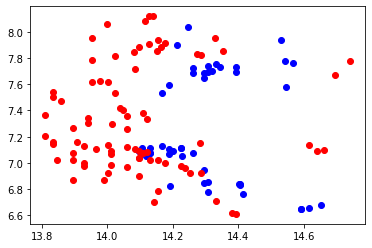

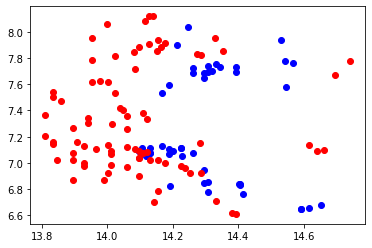

In [15]:
if 0:
    case_set_test = rwf.test_course_evalues(file_name,20)
items = [1,2]
evalues = ["end_time", "err_distance", "direction_shake","speed","next_direction"]
rwf.print_compare_set(case_set_test,items,evalues)
sets = [0,16]
items_no = [0,1]
rwf.test_compare_display(case_set_test,sets,items_no,True,False)

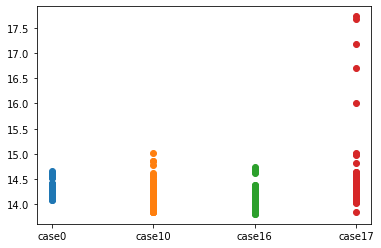

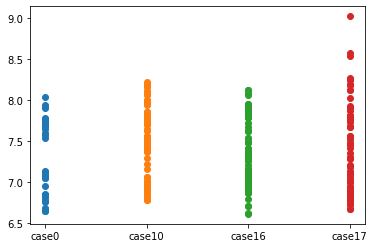

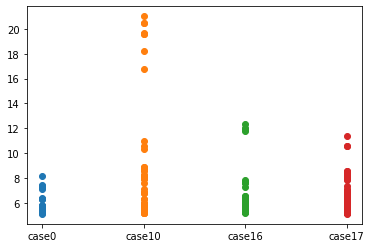

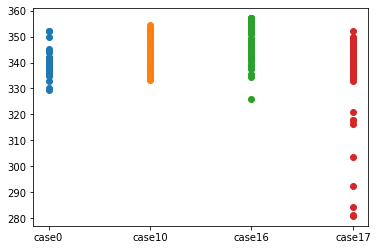

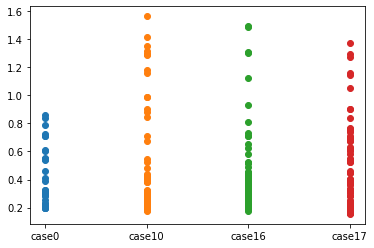

In [13]:
sets = [0,10,16,17]
items_no = [0,1,2,3,4]
rwf.test_compare_display(case_set_test,sets,items_no,False,True)

In [16]:
#v=rf.save_drive_orbit(problem,Kis,fpos,lms,10,False,3)
#save_control_values(problem.obj_control)

In [ ]:
#アルゴリズムの性能評価
hv = 0
rm = 0
ref_point=np.array([100,100,100])
b = eaf.evaluation_algorithm(res,hv,rm,ref_point)

In [ ]:
#個体のばらつき具合確認
if 0:
    eaf.print_object_space(res,problem,0,1)
    eaf.print_norm_object_space(res,0,1)
    
#個体の選択（重みバージョン）
if 0:
    weights = np.array([0.6,0.4])
    eaf.print_pseudo_weights(res,weights,0,1)
    eaf.print_asf(res,weights,0,1)

In [ ]:
F = res.F
fl = F.min(axis=0)
fu = F.max(axis=0)
print(f"Scale f1: [{fl[0]}, {fu[0]}]")
print(f"Scale f2: [{fl[1]}, {fu[1]}]")

In [ ]:
def app_count_calc(problem,Kis,xy,r):
    #lms =of.lms_produce(1,1)
    lms = of.circle_pos_produce(12,r)
    app1_count =np.zeros_like(problem.obj_control.fuzzy1.rule)
    app2_count =np.zeros_like(problem.obj_control.fuzzy2.rule)
    for lm in lms:
        #fpos = of.fpos_decision(lm[0],lm[1],1)
        fpos = np.array([xy[0],xy[1],xy[2]])
        datas = rf.drive_test(problem,Kis,fpos,lm,30)
        for x1 in problem.obj_control.fuzzy1.appearanceList:
            app1_count[x1[0]][x1[1]][x1[2]]+=1
        for x2 in problem.obj_control.fuzzy2.appearanceList:
            app2_count[x2[0]][x2[1]]+=1
    print(app1_count)
    print(app2_count)
    return app2_count

def circle_fpos_produce(n,r):
    fposs = []
    for i in range(0,n):
        theta = i*math.pi/n
        x = r*math.cos(theta)
        y = r*math.sin(theta)
        fposs.append(np.array([x,y,theta]))
    return fposs

In [ ]:
'''import ast
string = (str(ga_para_values[6]))
output = ast.literal_eval(string)
output'''

In [ ]:
'''a = np.array(
        [[  60,   24,   25,  298,  297,   36,   36],
       [  36,    0,    1,  176,  229,   84,   54],
       [   0,   12,  500, 1586, 1140,   60,   42],
       [  36,   12, 2533, 4173, 1664,   24,   24],
       [ 156,  132, 2154, 2689,  631,   12,    0],
       [ 300,  264,  180,   36,    0,    0,    0],
       [ 180,  132,   68,   14,   18,   24,   24]])'''